In [14]:
import os
import sys
import numpy as np
import cv2

import torch
from tqdm import tqdm

# Dataset
from dataset.frames_dataset_with_lmks import FramesDataset
from torch.utils.data import DataLoader

# Models
from modulesiris.generator import OcclusionAwareGenerator
import imageio

# Loss
device = 'cuda'

def load_model(ckpt):
    checkpoint = torch.load(ckpt, map_location=device)
     # Model here
    dense_motion_params = {"block_expansion":64, "max_features": 1024, "num_blocks":5, "scale_factor":0.25, "using_first_order_motion":False,"using_thin_plate_spline_motion":True}
    G = OcclusionAwareGenerator(num_channels=3, num_kp=8, block_expansion=64, max_features=512, num_down_blocks=2,
                 num_bottleneck_blocks=6, estimate_occlusion_map=True, dense_motion_params=dense_motion_params, estimate_jacobian=True)
    
    G.load_state_dict(checkpoint["G_state_dict"], strict=True)
    G = G.to(device)
    return G

def draw_landmarks(img, lmks, color=(255,0,0)):
    img = np.ascontiguousarray(img)
    for a in lmks:
        cv2.circle(img,(int(round(a[0])), int(round(a[1]))), 1, color, -1, lineType=cv2.LINE_AA)

    return img


def vis(x, x_prime_hat, kp_src, kp_driving):
        """
        x: Bx3x1xHxW
        x_prime: Bx3x1xHxW
        x_prime_hat: Bx3x1xHxW
        kp_src: Bx1x10x2
        kp_driving: Bx1x10x2
        """
        _,_,h,w = x.shape
        x = x.detach().cpu().numpy()
        x_prime_hat = x_prime_hat.detach().cpu().numpy()


        kp_src = kp_src.detach().cpu().numpy()
        kp_driving = kp_driving.detach().cpu().numpy()

        for i, (x1, x3, ks, kd) in enumerate(zip(x, x_prime_hat, kp_src, kp_driving)):
            x1 = (np.transpose(x1, (1,2,0))*255.0).astype(np.uint8)
            x3 = (np.transpose(x3, (1,2,0))*255.0).astype(np.uint8)
            ks = (ks+1) * np.array([w,h]) / 2.0
            kd = (kd+1) * np.array([w,h]) / 2.0
            x1 = draw_landmarks(x1, ks)
            x3 = draw_landmarks(x3, ks)
            x3 = draw_landmarks(x3, kd, color=(0,255,255))

            img = np.hstack((x1, x3))
            return img



def synthize_kp_driving(kp_src, delta_x=None, delta_y=None):
    kp_driving = {}
    kp_driving["value"] =  kp_src["value"].clone()

    if delta_x is  None:
        delta_x = np.random.uniform(-0.15, 0.15)
    if delta_y is  None:
        delta_y = np.random.uniform(-0.15, 0.15)

    kp_driving["value"][:,-2:,0] = kp_driving["value"][:,-2:,0] + delta_x
    kp_driving["value"][:,-2:,1] = kp_driving["value"][:,-2:,1] + delta_y
    return kp_driving


from skimage import io, img_as_float32

# Load model
# ckpt = "checkpoints/motion_iris/11.pth.tar"
# ckpt = "checkpoints/motion_iris_fix_motion_equation/15.pth.tar"
# ckpt = "checkpoints/motion_iris_fix_motion_test/8.pth.tar"
# ckpt = "checkpoints/motion_iris_fix_motion_test_zero_order_motion/20.pth.tar"
ckpt = "checkpoints/motion_iris_thin_plate_spline_motion_more_control_points/1.pth.tar"


G = load_model(ckpt = ckpt)
G.eval()

# Dataset
root_dir = "./data/eth_motion_data"
augmentation_params = {"flip_param" : {"horizontal_flip": False, "time_flip":False}, "jitter_param" :{"brightness":0.1, "contrast":0.1, "saturation":0.1, "hue":0.1}}
dataset = FramesDataset(root_dir, frame_shape=(256, 256, 3), id_sampling=False, is_train=True,
             random_seed=0, pairs_list=None, augmentation_params=augmentation_params)


# batchdata = dataset[index]
# _, x = batchdata["driving"], batchdata["source"]
# _, kp_src = batchdata["lmks_driving"], batchdata["lmks_source"]

# Fake image
def synthesize_image(src_path, delta_x, delta_y):
    src = cv2.imread(src_path)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    src = cv2.resize(src, (256, 256)) #BxCxDxH,W
    src = src/255.0
    x  = np.transpose(src, (2,0,1)) # 3x256x256
    kp_src = {"value": torch.FloatTensor([[-0.6569526,  -0.4652962 ],
                                            [-0.8053093,   0.41196918],
                                            [-0.09422648,  0.94234025],
                                            [ 0.45966482,  0.46068788],
                                            [ 0.6399733,  -0.2717154 ],
                                            [ 0.14487517,  0.18668795],
                                            [-0.2136181,  -0.31389177],
                                            [ 0.373667,   -0.22871798]])}


    x = torch.FloatTensor(x)
    kp_src["value"] = torch.FloatTensor(kp_src["value"])
    x = x.to(device) 
    kp_src["value"] = kp_src["value"].to(device)
    kp_src["value"].unsqueeze_(0) 
    x.unsqueeze_(0) 
    kp_driving = synthize_kp_driving(kp_src, delta_x, delta_y)
    kp_driving["value"] = kp_driving["value"].to(device)
    prediction = G(source_image=x, kp_driving=kp_driving, kp_source=kp_src)
    img_out = vis(x, prediction["prediction"], kp_src["value"], kp_driving["value"])

    return img_out, prediction


YOOOOOOOOOOO dense_motion_params :{'block_expansion': 64, 'max_features': 1024, 'num_blocks': 5, 'scale_factor': 0.25, 'using_first_order_motion': False, 'using_thin_plate_spline_motion': True}
Use predefined train-test split.


# Debug transform

In [ ]:
from modulesiris.loss import Transform
transform = Transform(1, sigma_affine=0.05, sigma_tps=0.005, points_tps=5)
src = cv2.imread("trinh.png")
plt.imshow(src)
# src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
src = cv2.resize(src, (256, 256)) #BxCxDxH,W
# src = src/255.0
src  = np.transpose(src, (2,0,1)) # 3x256x256
src = torch.FloatTensor([src])
kp = torch.FloatTensor([[[-0.2136181,-0.31389177]]])
print((kp+1)*127, kp.shape)

In [ ]:
transform = Transform(1, sigma_affine=0.15, sigma_tps=0.005, points_tps=5)
new_img = transform.transform_frame(src)
new_img = new_img[0].permute(1,2,0).detach().cpu().numpy()
new_img = new_img.astype(np.uint8)
plt.imshow(new_img)
new_kp = transform.warp_coordinates(kp)
print((new_kp+1)*127)

In [ ]:
def make_coordinate_grid(spatial_size, type):
    """
    Create a meshgrid [-1,1] x [-1,1] of given spatial_size.
    """
    h, w = spatial_size
    x = torch.arange(w).type(type)
    y = torch.arange(h).type(type)

    x = (2 * (x / (w - 1)) - 1)
    y = (2 * (y / (h - 1)) - 1)

    yy = y.view(-1, 1).repeat(1, w)
    xx = x.view(1, -1).repeat(h, 1)

    meshed = torch.cat([xx.unsqueeze_(2), yy.unsqueeze_(2)], 2)

    return meshed
a = make_coordinate_grid((256,256), new_kp.type())
a.shape

# Debug JacobinanEstimation

In [ ]:
from modulesiris.util import Hourglass, AntiAliasInterpolation2d, make_coordinate_grid, kp2gaussian
down = AntiAliasInterpolation2d(channels=3, scale=0.25)
jaco_estimator =  G.dense_motion_network.jacobian_estimator

# Kp source and Kp driving
kp_src = {"value": torch.FloatTensor([[-0.2136181,-0.31389177],[0.373667,-0.22871798]])}

kp_src["value"] = torch.FloatTensor(kp_src["value"])
kp_src["value"] = kp_src["value"].to(device)
kp_src["value"].unsqueeze_(0) 
kp_driving = synthize_kp_driving(kp_src, 0.07, 0.07)


# Heatmap
src = cv2.imread("trinh.png")
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
src = cv2.resize(src, (256, 256)) #BxCxDxH,W
src = src/255.0
src  = np.transpose(src, (2,0,1)) # 3x256x256
src = torch.FloatTensor([src])
src = down(src)
spatial_size = src.shape[2:]
h_d = kp2gaussian(kp_driving, spatial_size=spatial_size, kp_variance=0.01)
h_s = kp2gaussian(kp_src, spatial_size=spatial_size, kp_variance=0.01)
heatmap = h_d + h_s
heatmap = heatmap[0].permute(1,2,0).detach().cpu().numpy()
print(heatmap.shape)
plt.imshow(heatmap[:,:,1])

print(np.max(heatmap), np.min(heatmap))


In [ ]:
torch.max(h_d)

In [ ]:
heatmap

In [2]:

from ipywidgets import interact, interactive, fixed, interact_manual, Image
import cv2


@interact(delta_x=(-0.15, 0.15, 0.005), delta_y=(-0.15, 0.15, 0.005))
def synthesize(delta_x, delta_y):
    img, prediction = synthesize_image(src_path="trinh.png", delta_x=delta_x, delta_y=delta_y)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_bytes = cv2.imencode('.png', img)[1].tobytes()
    widget = Image(value=img_bytes, format='png')
    return (widget)
    # return x

interactive(children=(FloatSlider(value=0.0, description='delta_x', max=0.15, min=-0.15, step=0.005), FloatSli…

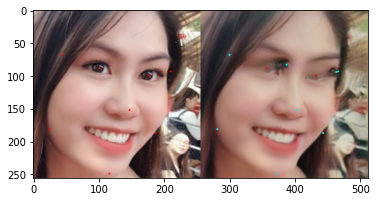

In [17]:
img, predictions = synthesize_image(src_path="trinh.png", delta_x=0.24, delta_y=-0.04)
plt.imshow(img)

torch.Size([1, 3, 64, 64, 2])


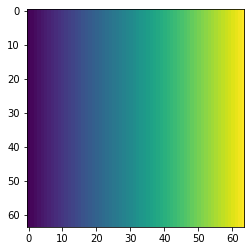

In [4]:
motion = predictions["sparse_motion"]
print(motion.shape)
import matplotlib.pyplot as plt
d1 = motion[0][1].detach().permute(2,0,1)[0].cpu().numpy() # left iris x
d2 = motion[0][2].detach().permute(2,0,1)[0].cpu().numpy() # left iris x

i = motion[0][0].detach().permute(2,0,1)[0].cpu().numpy() # indentity x
# i = ((i+1)*127).astype(np.uint8)
plt.imshow(i)

In [ ]:
plt.imshow(d1-i)


In [ ]:
mask = predictions["mask"]
print(mask.shape)
m = mask[0].detach().permute(1,2,0).cpu().numpy()
plt.imshow(m*255)

In [ ]:
sparse_motion = motion.permute(0, 1, 4, 2, 3)
mask = predictions["mask"]
mask = mask.unsqueeze(2)

print(sparse_motion.shape, mask.shape)
deformation = (sparse_motion * mask).sum(dim=1)
print(deformation.shape)
deformation = deformation.permute(0, 2, 3, 1)
print(deformation.shape)

deformation = deformation[0].permute(2,0,1)[0].detach().cpu().numpy()
plt.imshow(deformation-i)



In [ ]:
from matplotlib.pylab import cm

# plt.imshow(d2-i)
# img = ((d2-i+1.0)*127.0).astype(np.uint8)

img = (d1-i)
# img = (d1)


# img = cm.viridis(img)
plt.imshow(img)
# 
# print(img.shape)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# image_bgr = cv2.applyColorMap(img, get_mpl_colormap('bwr'))
cv2.imwrite("test.png", img)

In [ ]:
d1[0,0]

In [ ]:
deformed = predictions["deformed"]
print(deformed.shape)
deformed = deformed[0].permute(1,2,0).detach().cpu().numpy()
plt.imshow(deformed)

In [ ]:
img, predictions = synthesize_image(src_path="trinh.png", delta_x=-0.07, delta_y=-0.07)
plt.imshow(img)


In [ ]:
sparse_deformed = predictions["sparse_deformed"]
print(sparse_deformed.shape, torch.max(sparse_deformed))
sparse_deformed = sparse_deformed[0][1].permute(1,2,0).detach().cpu().numpy()
plt.imshow(sparse_deformed)

# img = ((sparse_deformed-i+1.0))
# cv2.imwrite("test1.png", img)

In [ ]:
deformation = predictions["deformation"]
print(deformation.shape)
deformation = deformation[0].permute(2,0,1)[0].detach().cpu().numpy()
plt.imshow(deformation-i)

img = ((deformation-i+1.0))
cv2.imwrite("test1.png", img)

In [ ]:
predictions.keys()

In [ ]:
import matplotlib.pyplot as plt

heatmap_representation = predictions["heatmap_representation"]
print(heatmap_representation.shape)
heatmap_representation = heatmap_representation[0][2].permute(1,2,0).detach().cpu().numpy()
plt.imshow(heatmap_representation)


In [ ]:
import matplotlib.pyplot as plt

jacobianD2S = predictions["jacobianD2S"]
print(jacobianD2S.shape)
print(jacobianD2S)